# Data Science Capstone Assignment
## Segmenting and Clustering Neighbourhoods in Toronto
### *Graciela Carrillo*

## Section 1
### Web Scraping from Wikipedia 
(https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)

In [ ]:
# Install a pip packages in the current Jupyter kernel
import sys
!{sys.executable} -m pip install bs4
!{sys.executable} -m pip install lxml
!{sys.executable} -m pip install geocoder
!{sys.executable} -m pip install geopy

# Sends organic, grass-fed HTTP/1.1 requests
import requests

#### Data Collection

#### Step 1: Sending a HTTP request to a URL

In [6]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

# Assign the link of the website through which we are going to scrape the data
website_url = requests.get(url).text

#### Step 2: Parse the html content

In [ ]:
# Reading source code and creating a BeautifulSoup object
# It creates a parse tree for parsed pages that can be used to extract data from HTML,
# which is useful for web scraping. Prettify() function in BeautifulSoup will enable us
# to view how the tags are nested in the document.

from bs4 import BeautifulSoup
import lxml

# Fetch data 
soup = BeautifulSoup(website_url,features="html5")

# Print parsed data
print(soup.prettify())

#### Step 3: Analyze the HTML tag, where our content lives

In [8]:
# Initialise dictionary to store the data.
data = {}

#Get the table having the class wikitable
tor_table = soup.find("table", attrs={"class": "wikitable"})
tor_table_rows = tor_table.tbody.find_all("tr")  # contains 2 rows

In [9]:
# iterate over each row in the table and store the data row by row
data = []
for row in tor_table_rows:
    data.append([t.text.strip() for t in row.find_all('td')])

In [10]:
# Step 4: Save to pandas dataframe
import pandas as pd

df = pd.DataFrame(data, columns=['PostalCode', 'Borough', 'Neighbourhood'])
df = df[~df['PostalCode'].isnull()]  # to filter out bad rows
df.head()
df.describe()

,PostalCode,Borough,Neighbourhood
count,288,288,288
unique,180,12,209
top,M9V,Not assigned,Not assigned
freq,8,77,78


#### Step 5: Pre-processing

In [11]:
# Only process the cells that have an assigned borough.
df.drop(df[df['Borough']=="Not assigned"].index,axis=0, inplace=True)
df.head()
df.describe()

,PostalCode,Borough,Neighbourhood
count,211,211,211
unique,103,11,209
top,M8Y,Etobicoke,Runnymede
freq,8,45,2


#### Step 6: Combine neighbourhoods belonging to same postal code

In [35]:
# Groupby PostalCode and then aggregate over all the other columns
# Note: The groupby column becomes the index. Reset the index to get it back with .reset_index()
df_cleaned=df.groupby("PostalCode").agg(lambda x:','.join(set(x))).reset_index()

# Assign borough names to 'Not assigned' neighbourhoods
df_cleaned.loc[df_cleaned['Neighbourhood']== "Not assigned",
               'Neighbourhood'] = df_cleaned.loc[df_cleaned['Neighbourhood'] == "Not assigned",'Borough']
df_cleaned.head(10)

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern,Rouge"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Morningside,Guildwood,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Ionview,Kennedy Park,East Birchmount Park"
7,M1L,Scarborough,"Golden Mile,Clairlea,Oakridge"
8,M1M,Scarborough,"Cliffside,Scarborough Village West,Cliffcrest"
9,M1N,Scarborough,"Cliffside West,Birch Cliff"


In [31]:
# Print dimensions of data frame
print('Shape:', df_cleaned.shape)

Shape: (103, 3)


## Section 2

### Get latitude and longitude of neighbourhoods

#### Step 1: Retrieving latitude and longitude for sample data to check code

In [54]:
import geocoder  # convert an address into latitude and longitude values

# generating sample for testing  
rows = df_cleaned.sample(frac =.10) 
  
# checking if sample is 0.25 times data or not 
if (0.10*(len(df_cleaned))== len(rows)): 
    print( "Cool") 
    print(len(df_cleaned), len(rows))

# Extract postal codes as list
postcodes_lst = rows['PostalCode'].tolist()

# Generate empty lists to store data
latitude = []
longitude = []

# Loop through each post code and retrieve lat and long
# used geocoder.argis instead of google
for i in postcodes_lst:
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(i))
        lat_lng_coords = g.latlng
    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])

# add to dataframe as new colums
rows['Latitude'] = latitude
rows['Longitude'] = longitude

# display pandas df
rows

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
53,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.655120,-79.362640
58,M5H,Downtown Toronto,"Adelaide,Richmond,King",43.649515,-79.382503
55,M5C,Downtown Toronto,St. James Town,43.651210,-79.375481
19,M2K,North York,Bayview Village,43.781015,-79.380542
56,M5E,Downtown Toronto,Berczy Park,43.645160,-79.373675
28,M3H,North York,"Downsview North,Wilson Heights,Bathurst Manor",43.757565,-79.448191
40,M4J,East York,East Toronto,43.688765,-79.334175
72,M6B,North York,Glencairn,43.707990,-79.448367
97,M9M,North York,"Emery,Humberlea",43.733760,-79.537522
12,M1S,Scarborough,Agincourt,43.793940,-79.267983


#### Step 2 : Repeat, now with full dataset

In [55]:
# Extract postal codes as list
lst = df_cleaned['PostalCode'].tolist()

# Generate empty lists to store data
latitude = []
longitude = []

# Loop through each post code and retrieve lat and long
# used geocoder.argis instead of google
for i in lst:
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(i))
        lat_lng_coords = g.latlng
    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])

# add to dataframe as new colums
df_cleaned['Latitude'] = latitude
df_cleaned['Longitude'] = longitude

# display pandas df
df_cleaned

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern,Rouge",43.811525,-79.195517
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.785730,-79.158750
2,M1E,Scarborough,"Morningside,Guildwood,West Hill",43.765690,-79.175256
3,M1G,Scarborough,Woburn,43.768359,-79.217590
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440
...,...,...,...,...,...
98,M9N,York,Weston,43.704855,-79.517552
99,M9P,Etobicoke,Westmount,43.696300,-79.530399
100,M9R,Etobicoke,"Richview Gardens,Kingsview Village,St. Phillip...",43.686915,-79.557276
101,M9V,Etobicoke,"Mount Olive,South Steeles,Thistletown,Silverst...",43.743205,-79.584701


#### Step 3: Save data set

In [ ]:
# check directory
!pwd

#write dataframe to file
df_cleaned.to_csv("toronto_geodata.csv", index = False) 


## Section 3

### Explore, segment and cluster

In [1]:
#read data set back
import pandas as pd

toronto_data = pd.read_csv("toronto_geodata.csv")

toronto_data.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern,Rouge",43.811525,-79.195517
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.785730,-79.158750
2,M1E,Scarborough,"Morningside,Guildwood,West Hill",43.765690,-79.175256
3,M1G,Scarborough,Woburn,43.768359,-79.217590
4,M1H,Scarborough,Cedarbrae,43.769688,-79.239440


#### Step 1: Visualise the data

In [2]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

print('Libraries imported.')

Libraries imported.


In [3]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_t = location.latitude
longitude_t = location.longitude
print('The geograpical coordinates of Toronto is {}, {}.'.format(latitude_t, longitude_t))

The geograpical coordinates of Toronto is 43.653963, -79.387207.


In [5]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude_t, longitude_t], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Step 2: Explore first neighbourhoods in Data Frame

#### We explore Downtown Toronto. Specifically the centre of Toronto's Financial District, Bay Street.

In [ ]:
# Define Foursquare Credentials 

CLIENT_ID = 'XXX' # your Foursquare ID
CLIENT_SECRET = 'XXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [7]:
# Extract Central bay from df
toronto_data.head()
toronto_data[toronto_data['Neighbourhood'].str.contains("Central Bay")]

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
57,M5G,Downtown Toronto,Central Bay Street,43.656091,-79.38493


In [8]:
# Retrive values of latitude and longitude of first neighbourhood

neighborhood_latitude = toronto_data.loc[57, 'Latitude'] # neighbourhood latitude value
neighborhood_longitude = toronto_data.loc[57, 'Longitude'] # neighbourhood longitude value

neighborhood_name = toronto_data.loc[57, 'Neighbourhood'] # neighbourhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Central Bay Street are 43.65609081300005, -79.38492999999994.


#### Step 3: Get the top 100 venues that are in Central Bay Street, Downtown Toronto, within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [9]:
# # limit of number of venues returned by Foursquare API
LIMIT = 100

# define radius
radius = 500 

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

All the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [11]:
# Send the GET request and examine the results
import requests
results = requests.get(url).json()
#results

In [12]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [13]:
from pandas.io.json import json_normalize

# Clean Json and store it in pandas df
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter colums
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =  nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,The Queen and Beaver Public House,Gastropub,43.657472,-79.383524
1,Japango,Sushi Restaurant,43.655268,-79.385165
2,Jimmy's Coffee,Coffee Shop,43.658421,-79.385613
3,Tsujiri,Tea Room,43.655374,-79.385354
4,Red Lobster,Seafood Restaurant,43.656328,-79.383621


In [14]:
# How many venues
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

98 venues were returned by Foursquare.


#### Step 4:  Explore all neighbourhoods in Toronto

In [15]:
# Function to loop for venues through all neighbourhoods

def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
         # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we run the above function on each neighborhood and create a new dataframe called *toronto_venues*.

In [ ]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude'],
                                 radius = 500
                                  )

Check the size of the resulting dataframe

In [17]:
print(toronto_venues.shape)
toronto_venues.head()

(2463, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern,Rouge",43.811525,-79.195517,Canadian Appliance Source Whitby,43.808353,-79.191331,Home Service
1,"Highland Creek,Rouge Hill,Port Union",43.785730,-79.158750,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Morningside,Guildwood,West Hill",43.765690,-79.175256,Homestead Roofing Repair,43.765140,-79.178663,Construction & Landscaping
3,"Morningside,Guildwood,West Hill",43.765690,-79.175256,Heron Park Community Centre,43.768867,-79.176958,Gym / Fitness Center
4,"Morningside,Guildwood,West Hill",43.765690,-79.175256,Heron Park,43.769327,-79.177201,Park


Venues returned per each neighborhood

In [18]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide,Richmond,King",100,100,100,100,100,100
Agincourt,16,16,16,16,16,16
"Agincourt North,Steeles East,L'Amoreaux East,Milliken",1,1,1,1,1,1
"Alderwood,Long Branch",6,6,6,6,6,6
Bayview Village,3,3,3,3,3,3
...,...,...,...,...,...,...
Woburn,6,6,6,6,6,6
"Woodbine Gardens,Parkview Hill",14,14,14,14,14,14
Woodbine Heights,15,15,15,15,15,15


Unique categories of venues

In [19]:
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 254 unique categories.


### Step 5: Analise each neighbourhood separately

In [20]:
# One Hot Encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix = "", prefix_sep = "")

## Add neighbourhood column back to df
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood']

# Move neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

# display
toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Malvern,Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Highland Creek,Rouge Hill,Port Union",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Morningside,Guildwood,West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Morningside,Guildwood,West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Morningside,Guildwood,West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# New df dimensions
toronto_onehot.shape

(2463, 255)

Group rows by neighbourhood and by taking the mean and the frequency of occurrence of each category

In [22]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide,Richmond,King",0.0,0.0,0.030000,0.0,0.01,0.0,0.0,0.03,0.000000,...,0.000000,0.0,0.010000,0.0,0.0,0.0000,0.01,0.0,0.0,0.0
1,Agincourt,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0625,0.00,0.0,0.0,0.0
2,"Agincourt North,Steeles East,L'Amoreaux East,M...",0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.00,0.0,0.0,0.0
3,"Alderwood,Long Branch",0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.166667,...,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.00,0.0,0.0,0.0
4,Bayview Village,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.000000,...,0.333333,0.0,0.000000,0.0,0.0,0.0000,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Woburn,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.00,0.0,0.0,0.0
96,"Woodbine Gardens,Parkview Hill",0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.071429,...,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.00,0.0,0.0,0.0
97,Woodbine Heights,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.00,0.0,0.0,0.0
98,York Mills West,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0000,0.00,0.0,0.0,0.0


Get each neighbourhood along with its top 5 most common venues

In [ ]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

Put that in pandas data frame

In [24]:
# Function to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
import numpy as np

# New dataframe ordered
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

        # create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], 
                                                                          num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide,Richmond,King",Coffee Shop,Café,Hotel,Asian Restaurant,Gastropub
1,Agincourt,Chinese Restaurant,Shopping Mall,Supermarket,Hong Kong Restaurant,Badminton Court
2,"Agincourt North,Steeles East,L'Amoreaux East,M...",Pharmacy,Yoga Studio,Donut Shop,Fish Market,Fish & Chips Shop
3,"Alderwood,Long Branch",Convenience Store,Dance Studio,Sandwich Place,Gym,Pub
4,Bayview Village,Trail,Construction & Landscaping,Park,Farm,Eastern European Restaurant


### Step 6:  Cluster Neighbourhoods
Running k-means to cluster neighbourhoods

#### Determine optimal k for K-means clustering

In [26]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [27]:
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)
toronto_grouped_clustering.head()

,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.0,0.03,0.0,0.01,0.0,0.0,0.03,0.000000,0.0,...,0.000000,0.0,0.01,0.0,0.0,0.0000,0.01,0.0,0.0,0.0
1,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,...,0.000000,0.0,0.00,0.0,0.0,0.0625,0.00,0.0,0.0,0.0
2,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,...,0.000000,0.0,0.00,0.0,0.0,0.0000,0.00,0.0,0.0,0.0
3,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.166667,0.0,...,0.000000,0.0,0.00,0.0,0.0,0.0000,0.00,0.0,0.0,0.0
4,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,...,0.333333,0.0,0.00,0.0,0.0,0.0000,0.00,0.0,0.0,0.0


For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre.

In [28]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

As k increases, the sum of squared distance tends to zero. Imagine we set k to its maximum value n (where n is number of samples) each sample will form its own cluster meaning sum of squared distances equals zero.
Below is a plot of sum of squared distances for k in the range specified above. If the plot looks like an arm, then the elbow on the arm is optimal k.

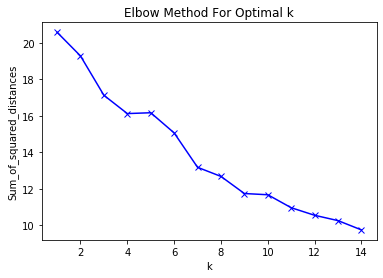

In [29]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Elbow is not very clear. We'll use Density-Based Spatial Clustering instead.

In [73]:
#!{sys.executable} -m pip install yellowbrick
from sklearn.cluster import DBSCAN 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 
from sklearn import metrics
%matplotlib inline

In [78]:
# Compute DBSCAN

# Epsilon 0.5, min 10

db = DBSCAN(eps=0.5, min_samples=3).fit(toronto_grouped_clustering)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
toronto_grouped_clustering["Cluster_Labels"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 
n_noise_ = list(labels).count(-1)

# A sample of clusters
toronto_grouped_clustering['Cluster_Labels'].describe()

count    100.000000
mean      -0.160000
std        0.443129
min       -1.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: Cluster_Labels, dtype: float64

In [79]:
# Number of clusters in labels, ignoring noise if present.
print('Estimated number of clusters: %d' % realClusterNum)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(toronto_grouped_clustering, labels))

Estimated number of clusters: 2
Estimated number of noise points: 19
Silhouette Coefficient: 0.547


The clusters resulting from the DBSCAN analysis have a relatively large silhouette value (usually 0.6 or greater,which we approximate here), indicating that the clusters are well separated.

For outliers, the cluster label is -1

In [80]:
set(labels)

{-1, 0, 1}

#### Step 7:  Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [ ]:
# Add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster_Labels', db.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighbourhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
toronto_merged.head() # check the last columns!

In [82]:
# Cluster_Labels as integers, for function to add map markers to work

toronto_merged.dropna(inplace = True) 
toronto_merged.Cluster_Labels = toronto_merged.Cluster_Labels.astype(int)
toronto_merged.dtypes

PostalCode                object
Borough                   object
Neighbourhood             object
Latitude                 float64
Longitude                float64
Cluster_Labels             int64
1st Most Common Venue     object
2nd Most Common Venue     object
3rd Most Common Venue     object
4th Most Common Venue     object
5th Most Common Venue     object
dtype: object

#### Step 8: Visualise resulting clusters

In [83]:
# Geographical coordinates, toronto
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_t = location.latitude
longitude_t = location.longitude
print('The geograpical coordinates of Toronto is {}, {}.'.format(latitude_t, longitude_t))

# Create map
map_clusters = folium.Map(location=[latitude_t, longitude_t], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], 
                                  toronto_merged['Neighbourhood'], toronto_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

The geograpical coordinates of Toronto is 43.653963, -79.387207.


### Final Step: Examine Clusters
#### Now, we examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we assign a name to each cluster.

**Cluster 1** : *Restaurants/Food related*

In [84]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 0, 
                   toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,Scarborough,0,Coffee Shop,Korean Restaurant,Soccer Field,Park,Business Service
5,Scarborough,0,Restaurant,Train Station,Grocery Store,Indian Restaurant,Fast Food Restaurant
6,Scarborough,0,Discount Store,Convenience Store,Coffee Shop,Department Store,Farm
7,Scarborough,0,Bakery,Bus Line,Coffee Shop,Intersection,Soccer Field
8,Scarborough,0,Fast Food Restaurant,Pizza Place,Burger Joint,Discount Store,Coffee Shop
...,...,...,...,...,...,...,...
98,York,0,Pizza Place,Fried Chicken Joint,Convenience Store,Pharmacy,Diner
99,Etobicoke,0,Pizza Place,Middle Eastern Restaurant,Sandwich Place,Discount Store,Coffee Shop
100,Etobicoke,0,Pizza Place,Bus Line,Arts & Crafts Store,Music Venue,Fish & Chips Shop
101,Etobicoke,0,Grocery Store,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Coffee Shop


**Cluster 2** : *Services*

In [85]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == 1, 
                   toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Scarborough,1,Park,Gym / Fitness Center,Construction & Landscaping,Eastern European Restaurant,Electronics Store
17,North York,1,Dog Run,Residential Building (Apartment / Condo),Donut Shop,Fish Market,Fish & Chips Shop
19,North York,1,Trail,Construction & Landscaping,Park,Farm,Eastern European Restaurant
20,North York,1,Music Venue,Yoga Studio,Dumpling Restaurant,Fish Market,Fish & Chips Shop
25,North York,1,Food & Drink Shop,Park,Yoga Studio,Dumpling Restaurant,Fish Market
26,North York,1,Spa,Soccer Field,Burger Joint,Park,Falafel Restaurant
31,North York,1,Gym / Fitness Center,Hotel,Park,Yoga Studio,Eastern European Restaurant
32,North York,1,Spa,Business Service,Moving Target,Park,Eastern European Restaurant
37,East Toronto,1,Trail,Health Food Store,Pub,Neighborhood,Fast Food Restaurant
44,Central Toronto,1,Bus Line,Swim School,Yoga Studio,Flower Shop,Fish Market


**Outliers**

In [87]:
toronto_merged.loc[toronto_merged['Cluster_Labels'] == -1, 
                   toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Scarborough,-1,Home Service,Dumpling Restaurant,Flea Market,Fish Market,Fish & Chips Shop
1,Scarborough,-1,Bar,Yoga Studio,Food,Flea Market,Fish Market
4,Scarborough,-1,Playground,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop
11,Scarborough,-1,Auto Garage,Yoga Studio,Dumpling Restaurant,Flea Market,Fish Market
14,Scarborough,-1,Pharmacy,Yoga Studio,Donut Shop,Fish Market,Fish & Chips Shop
64,Central Toronto,-1,Home Service,Dumpling Restaurant,Flea Market,Fish Market,Fish & Chips Shop
